In [9]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [18]:
DATASET_PATH = '/home/jupyter/work/resources/images'
MODEL_PATH = '/home/jupyter/work/resources/resnet18_letters.pth'

Вам предстоит создать алгоритм по деформации (выравниваню) автомобильных номеров и поместить его в функцию img_deformation.


! Вы не можете менять заданную OCR модель (дообучать тоже нельзя) и заданные шаблоны по разбиению изображения.

! Допустимы небольшие измениния трех основных .py файлов, если в этом есть необходимость для встраивания в ваши решения. Но их функционал должен быть сохранен.

# Файлы для работы с шаблонами

В разделе "Алогритм" показано что для чего нужно, так что имеет смысл сначала посетить его

## model.py

In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s

## template.py

Разбивает изображение на части по шаблонам

In [50]:
from pathlib import Path
import numpy as np

two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

def apply_template(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    crops = []
    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = sx * W, sy * H, ex * W, ey * H
        sx, sy, ex, ey = map(int, [sx, sy, ex, ey])
        crops.append(img[sy : ey, sx : ex])

    return crops


## Функция для деформации

Пропишите логику алгоритма по деформации внутри фунции img_deformation

In [6]:
pip install ultralytics==8.0.196

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

import os
HOME = os.getcwd()

idman_model = YOLO(f"{HOME}/best.pt")


def img_deformation(file_name: str):
    results = idman_model(file_name)
    
    for i, result in enumerate(results):
        masks = result.masks

        xy = masks.xy
        xy = np.concatenate(xy, axis=0)
        
        top_left = xy[np.argmin(xy[:, 0] + xy[:, 1])]
        bottom_left = xy[np.argmin(xy[:, 0] - xy[:, 1])]
        bottom_right = xy[np.argmax(xy[:, 0] + xy[:, 1])]
        top_right = xy[np.argmax(xy[:, 0] - xy[:, 1])]
        # Load image
        # image = cv2.imread(f"{filenames[i]}")

#         color = (255, 0, 0)  # Blue color in BGR
#         radius = 5

#         # Draw points using OpenCV
#         corner_points = [top_left, bottom_left, bottom_right, top_right]
#         for point in corner_points:
#           cv2.circle(image, (int(point[0]), int(point[1])), radius, color, -1)

#         # Display image with points
#         cv2_imshow(image)
#         plt.scatter(xy[:, 0], xy[:, 1], color='gray', s=10)  # Original points for reference
#         plt.scatter([p[0] for p in corner_points], [p[1] for p in corner_points], color='blue', s=50)  # Corner points
#         plt.title("Corner Points")
#         plt.show()
    
    # Преобразуем изображение в градации серого
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # # Применим гауссово размытие для уменьшения шума
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # # Применим пороговую обработку
    # _, thresholded = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY)

    # # Найдем контуры
    # contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # # Найдем контур с максимальной площадью (предполагаем, что это номерной знак)
    # max_contour = max(contours, key=cv2.contourArea)

    # # Найдем минимальный прямоугольник, охватывающий контур
    # rect = cv2.minAreaRect(max_contour)
    # box = cv2.boxPoints(rect)
    # box = np.int0(box)

    # Соединим найденные угловые точки
    # cv2.polylines(image, [box], isClosed=True, color=(0, 255, 0), thickness=2)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    # plt.show()
    top = 10
    bottom = top
    left = 10
    right = left

    # Define the padding color (here we use black, but you can change it to any color)
    border_color = [0, 0, 0]

    # Step 2: Add padding to the image
    
    pts = np.array([top_left, bottom_left, bottom_right, top_right], dtype="float32")
    warped = four_point_transform(cv2.imread(str(file_name)), pts)
    warped = cv2.resize(warped, (512,112))
    padded_image = cv2.copyMakeBorder(warped, top, bottom, left, right, cv2.BORDER_CONSTANT, value=border_color)

    # plt.imshow(warped)
    # plt.show()
    # warped = cv2.resize(warped, (512,112))
    # Покажем изображение с отмеченными точками
    # cv2.imshow('test', image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # print("Угловые точки номерного знака:")
    # for point in box:
    #     print(point)
    # plt.imshow(warped)
    # plt.show()

    # Define the padding color (here we use black, but you can change it to any color)

    # Step 2: Add padding to the image
    
    return padded_image


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped
    # return warped


## predict.py

Выполняет предсказание для изображений разбитых по 2 и 3 шаблону

In [79]:
import argparse
from pathlib import Path
from tqdm import tqdm

import cv2
import pandas as pd

#from template import apply_template
#from model import LettersPrediction

data_path = Path(DATASET_PATH)


regions_type = [2, 3]
model = LettersPrediction()


result = []
for p in tqdm(data_path.iterdir()):

    if not p.suffix in [".png", ".jpg", ".jpeg"]:
        continue
    result.append(
        {
            "image_name": p.stem,
            "prediction_region_length_2": "",
            "prediction_region_length_3": ""
        }
    )

    # img = cv2.imread(str(p))

    #вызов фунции деформации
    img = img_deformation(p)
    ########################

    img = cv2.resize(img, (512,112))

    for region_type in regions_type:

        crops = apply_template(img, region_type)

        lp_number = model.predict_series(crops)
        result[-1][f"prediction_region_length_{region_type}"] = lp_number

pd.DataFrame(result).to_csv('modelPredict.csv', index=False)



0it [00:00, ?it/s]
image 1/1 /home/jupyter/work/resources/images/de2fcb9205540951.jpg: 448x640 1 plate, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)
2it [00:00, 10.58it/s]
image 1/1 /home/jupyter/work/resources/images/dd1cf50b5fefe0f1.jpg: 224x640 1 plate, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /home/jupyter/work/resources/images/9fee83135ee732cf.jpg: 384x640 1 plate, 12.0ms
Speed: 1.9ms preprocess, 12.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
4it [00:00,  7.12it/s]
image 1/1 /home/jupyter/work/resources/images/9f8019f7cccd9a9b.jpg: 448x640 1 plate, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)
5it [00:00,  6.78it/s]
image 1/1 /home/jupyter/work/resources/images/9ff43d33601ca128.jpg: 544x640 1 plate, 11.8ms
Speed: 2.1ms preprocess, 11.8ms inference, 2.6ms postprocess pe

# Алгоритм

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

In [54]:
import matplotlib.pyplot as plt
import os

#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv2.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2):

    file_list = os.listdir(folder_path)
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(image_files):
            ax = axes.flat[i]
            img_path = os.path.join(folder_path, image_files[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if show_template:
                img = img_deformation(img_path)
                img = cv2.resize(img, (512,112))
                img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()


Визуализируем изображения из датасета

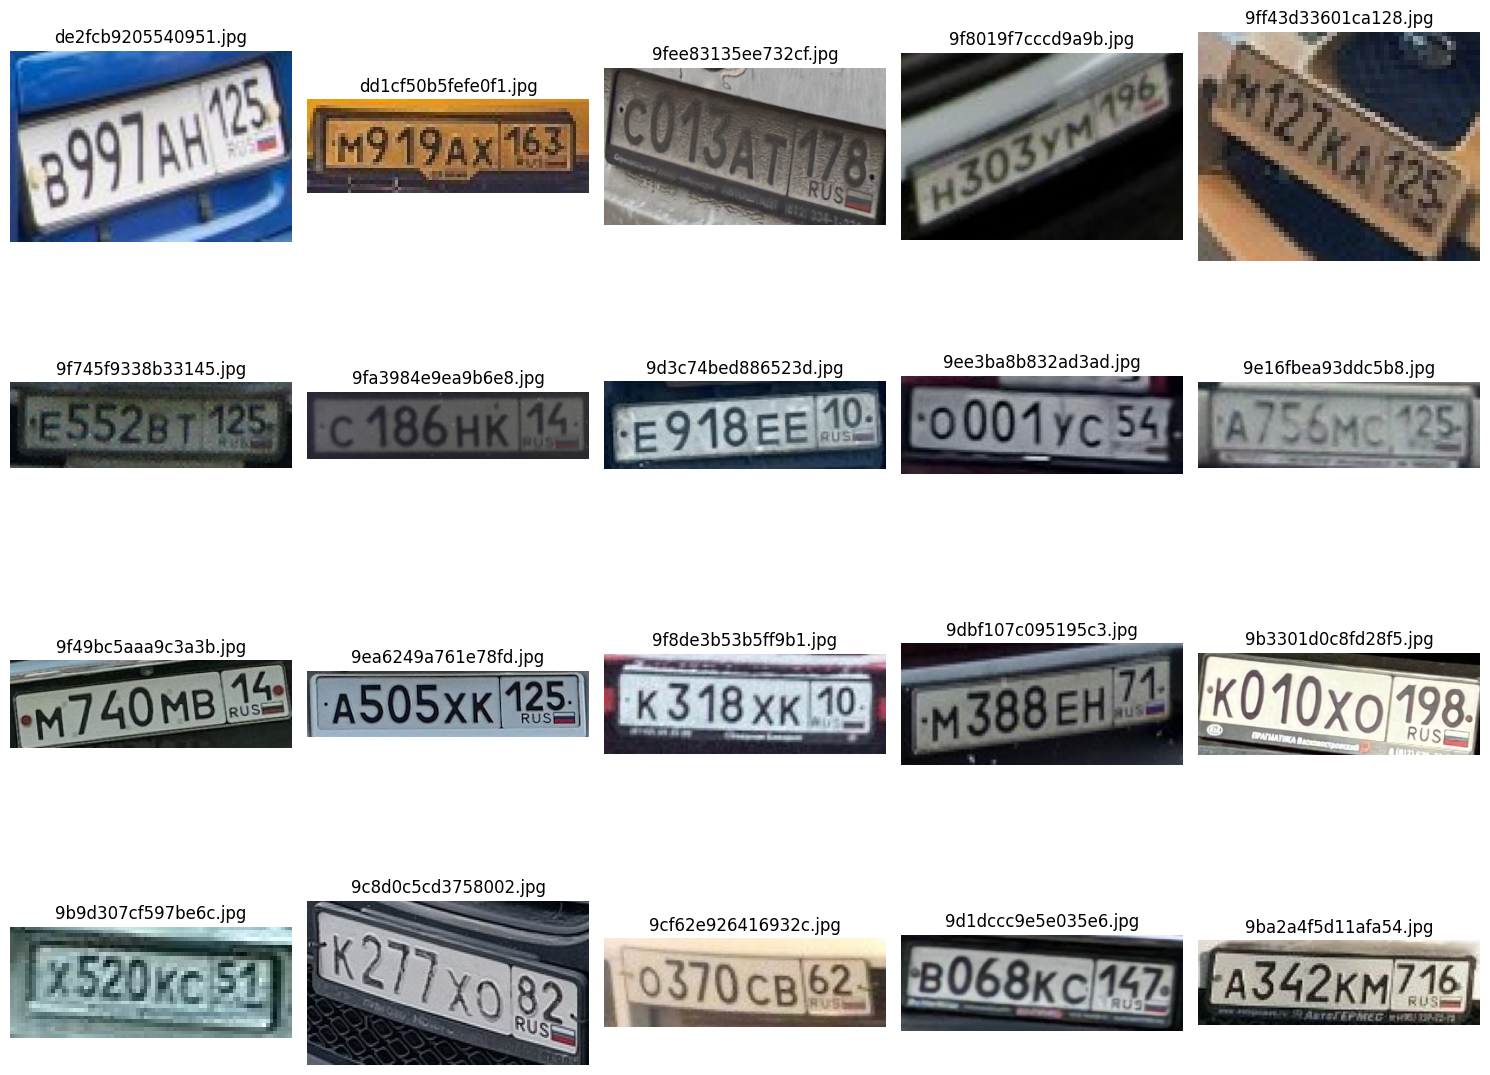

In [80]:
draw(DATASET_PATH, show_template=False)

Теперь визуализируем шаблон 2 для каждого изображения


image 1/1 /home/jupyter/work/resources/images/de2fcb9205540951.jpg: 448x640 1 plate, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/jupyter/work/resources/images/dd1cf50b5fefe0f1.jpg: 224x640 1 plate, 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /home/jupyter/work/resources/images/9fee83135ee732cf.jpg: 384x640 1 plate, 11.0ms
Speed: 1.5ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/jupyter/work/resources/images/9f8019f7cccd9a9b.jpg: 448x640 1 plate, 11.8ms
Speed: 1.8ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/jupyter/work/resources/images/9ff43d33601ca128.jpg: 544x640 1 plate, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /home/jupyter/work/resources/images/9f7

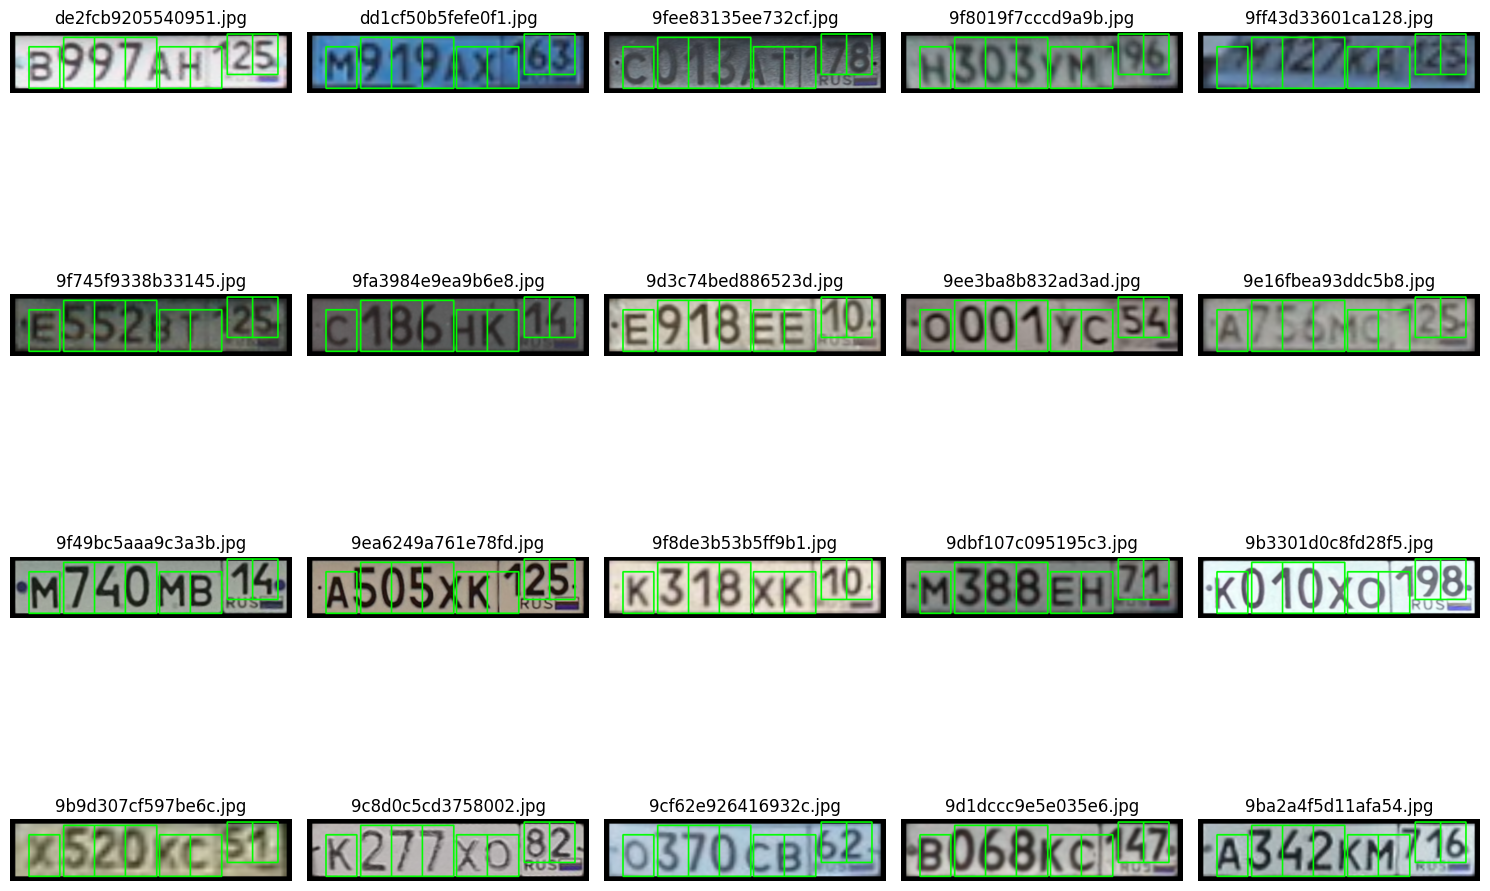

In [81]:
draw(DATASET_PATH, show_template=True)

Теперь визуализируем шаблон 3 для каждого изображения


image 1/1 /home/jupyter/work/resources/images/de2fcb9205540951.jpg: 448x640 1 plate, 13.0ms
Speed: 2.0ms preprocess, 13.0ms inference, 2.8ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/jupyter/work/resources/images/dd1cf50b5fefe0f1.jpg: 224x640 1 plate, 12.7ms
Speed: 1.2ms preprocess, 12.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /home/jupyter/work/resources/images/9fee83135ee732cf.jpg: 384x640 1 plate, 12.2ms
Speed: 1.7ms preprocess, 12.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/jupyter/work/resources/images/9f8019f7cccd9a9b.jpg: 448x640 1 plate, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/jupyter/work/resources/images/9ff43d33601ca128.jpg: 544x640 1 plate, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /home/jupyter/work/resources/images/9f7

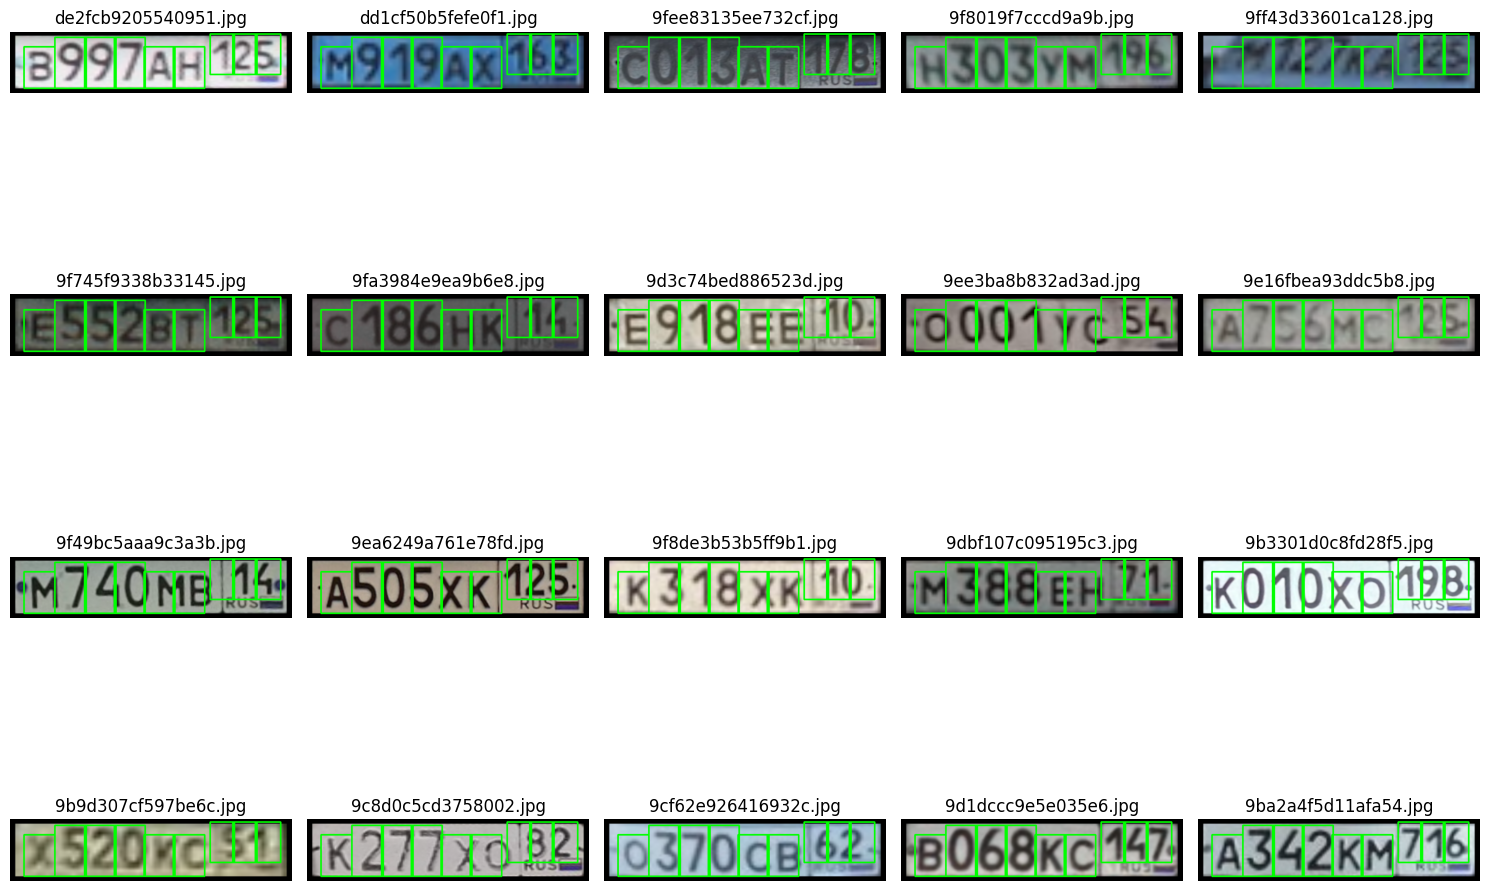

In [82]:
draw(DATASET_PATH, show_template=True, template = 3)

# Вывод модели

In [83]:
df = pd.read_csv('/home/jupyter/work/resources/modelPredict.csv')

Модель делает предсказание разбивая изображение и по шаблону 2 и по шаблону 3.

In [84]:
df

image_name prediction_region_length_2 prediction_region_length_3
0   de2fcb9205540951                   B997HT25                  B997AH125
1   dd1cf50b5fefe0f1                   M9TYOT63                  M919AXT63
2   9fee83135ee732cf                   C0T7TT78                  C013ATT78
3   9f8019f7cccd9a9b                   HYOYAM96                  H3O3YM196
4   9ff43d33601ca128                   1141YY33                  114411133
5   9f745f9338b33145                   E552MT25                  E552BT1C5
6   9fa3984e9ea9b6e8                   OM86HCH4                  O186HKTHE
7   9d3c74bed886523d                   E918EE1O                  E918EETTO
8   9ee3ba8b832ad3ad                   OOO1YC54                  OCOMH4154
9   9e16fbea93ddc5b8                   A744P125                  A756MC124
10  9f49bc5aaa9c3a3b                   M74OMB14                  M74OMET14
11  9ea6249a761e78fd                   A555KT25                  A5O5XC125
12  9f8de3b53b5ff9b1                   K318YC1Y                  K318Y4THY
13  9dbf107c095195c3                   M388EH7T                  M388EHT2E
14  9b3301d0c8fd28f5                   CYH6OT98                  CO1OOOT98
15  9b9d307cf597be6c                   452Y445T                  X520YC32T
16  9c8d0c5cd3758002                   K2T7OO82                  K2771CT82
17  9cf62e926416932c                   O37Y1B22                  O37OCBT22
18  9d1dccc9e5e035e6                   BO68CT47                  BO68KC147
19  9ba2a4f5d11afa54                   A342OM16                  A342KM716